In [15]:
import osmnx as ox
import networkx as nx
import geopandas as gpd
import pandas as pd
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt
import multiprocessing as mp
from time import time

#ox.config(use_cache=True, log_console=True)
ox.settings.use_cache = True
ox.settings.log_console = True

In [2]:
data_path = 'Data/'

# Stops

In [3]:
stop_df = pd.read_csv(data_path + 'MT_Stoppunkter_20220601.csv', delimiter=';', decimal=',', encoding='Latin-1')
stop_df = stop_df[['Stopkode', 'Pos.nr.', 'Kode til stoppunkt', 'Long name', 'UTM32_Easting', 'UTM32_Northing']]

In [4]:
stop_gdf = gpd.GeoDataFrame(stop_df, geometry=gpd.points_from_xy(x=stop_df['UTM32_Easting'], y=stop_df['UTM32_Northing']), crs='EPSG:25832')
stop_gdf = stop_gdf[['Stopkode', 'Pos.nr.', 'Kode til stoppunkt', 'Long name', 'geometry']]

In [5]:
print(stop_gdf.shape)
print(stop_gdf.crs)
stop_gdf.head()

(9369, 5)
EPSG:25832


,Stopkode,Pos.nr.,Kode til stoppunkt,Long name,geometry
0,50300503,1,503005031,Kirkevej v Lyreskovskolen,POINT (523706.000 6077181.000)
1,50300503,2,503005032,Kirkevej v Lyreskovskolen,POINT (448702.000 6191673.000)
2,50900125,1,509001251,Skamlingsbankens Rasteplads (Kolding),POINT (535589.000 6141575.000)
3,53100012,1,531000121,"Havneby, Østre Havnevej v Havnepladsen (Rømø)",POINT (472194.000 6104489.000)
4,55192250,1,551922501,Billund Lufthavn / Billund Airport (bus),POINT (509222.000 6177880.000)


# Kvadratnet

In [6]:
kvadratnet = gpd.read_file(data_path + 'befolkning_2024.shp', crs='EPSG:25832')
kvadratnet['geometry_center'] = kvadratnet.centroid

In [7]:
print(kvadratnet.shape)
print(kvadratnet[kvadratnet['antal_tal'] >= 0].shape)
print(kvadratnet.crs)
kvadratnet.head()

(114122, 4)
(50851, 4)
EPSG:25832


,antal_tal,antal_txt,geometry,geometry_center
0,NaN,5 eller derunder,"POLYGON ((551670.260 6169828.930, 551670.260 6...",POINT (551720.260 6169878.930)
1,NaN,5 eller derunder,"POLYGON ((551870.260 6169828.930, 551870.260 6...",POINT (551920.260 6169878.930)
2,NaN,5 eller derunder,"POLYGON ((551970.260 6169828.930, 551970.260 6...",POINT (552020.260 6169878.930)
3,NaN,5 eller derunder,"POLYGON ((551770.260 6169928.930, 551770.260 6...",POINT (551820.260 6169978.930)
4,NaN,5 eller derunder,"POLYGON ((551170.260 6170228.930, 551170.260 6...",POINT (551220.260 6170278.930)


# OSM

In [8]:
G = ox.graph_from_place('Region Midtjylland', network_type='walk', custom_filter=None)
G_proj = ox.project_graph(G, to_crs='EPSG:25832')

print('Edges: ', len(G_proj.edges))
print('Nodes: ', len(G_proj.nodes))

Edges:  1181064
Nodes:  474156


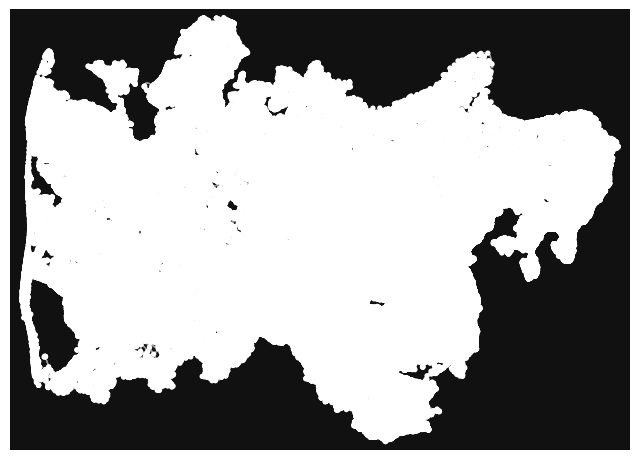

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [9]:
# walk
ox.plot_graph(G_proj)

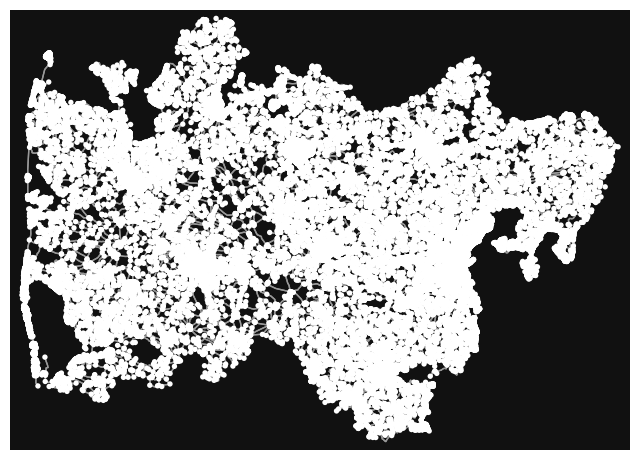

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [71]:
# drive
ox.plot_graph(G_proj)

# Algoritme - Naivt loop

In [59]:
time_start = time()

# Step 3: Define the centroid of the 100x100 meter cell
origin = kvadratnet.loc[10000]
n_closest = 20

# Step 4: Find the nearest node on the graph to the centroid
origin_node = ox.distance.nearest_nodes(G_proj, X=origin['geometry_center'].x, Y=origin['geometry_center'].y)

# Step 5: Initialize variables to track the nearest bus stop and its distance
target = None
target_node = None
min_distance = float('inf')

# find the closest stops based on the euclidean distance
closest_stops_gdf = deepcopy(stop_gdf)
#closest_stops_gdf['distance'] = ox.distance.euclidean(y1=closest_stops_gdf.geometry.y, x1=closest_stops_gdf.geometry.x, y2=origin.y, x2=origin.x)
closest_stops_gdf['distance'] = closest_stops_gdf['geometry'].distance(origin['geometry_center'])
closest_stops = closest_stops_gdf.nsmallest(n_closest, columns='distance')

# Step 6: Calculate the shortest path for each bus stop
for index, stop in closest_stops.iterrows():
    stop_point = stop.geometry
    stop_node = ox.distance.nearest_nodes(G_proj, X=stop_point.x, Y=stop_point.y)

    # Calculate the shortest path distance
    distance = nx.shortest_path_length(G_proj, source=origin_node, target=stop_node, weight='length')

    # Update nearest bus stop if this one is closer
    if distance < min_distance:
        print(stop['Long name'], distance)
        min_distance = deepcopy(distance)
        target = deepcopy(stop)
        target_node = stop_node

# Step 7: Output the result

time_end = time()

print(f"Nearest bus stop: {target['Long name']} with road distance: {min_distance:.2f} meters")
print('Execution time:', time_end - time_start, 'seconds')



Husoddevej/Bygaden (Horsens Kom) 298.342
Bygaden (Horsens Kom) 283.33700000000005
Nearest bus stop: Bygaden (Horsens Kom) with road distance: 283.34 meters
Execution time: 64.03135585784912 seconds


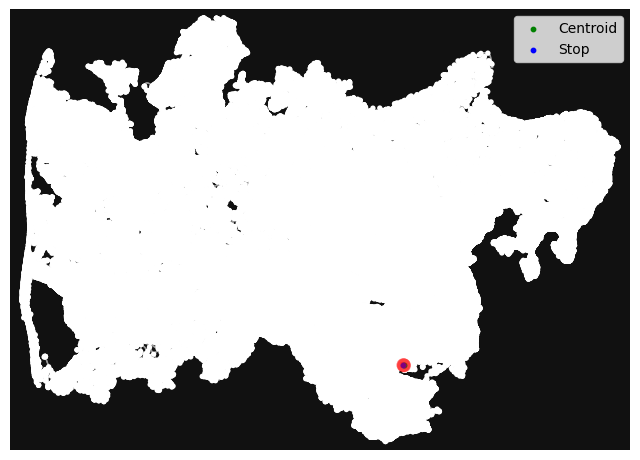

283.33700000000005


In [16]:
route = ox.shortest_path(G_proj, origin_node, target_node, weight='length')
distance = nx.shortest_path_length(G_proj, origin_node, target_node, weight='length')

fig, ax = ox.plot_graph_route(G_proj, route, show=False, close=False)
#fig, ax = ox.plot_graph(G_proj, show=False, close=False)
ax.scatter(origin['geometry_center'].x, origin['geometry_center'].y, c='green', s=10, label='Centroid')
ax.scatter(target['geometry'].x, target['geometry'].y, c='blue', s=10, label='Stop')
plt.legend()
plt.show()
print(distance)

In [102]:
def find_nearest_stop(G, origin, stop_gdf, N_closest=20):
    target = None
    target_node = None
    min_distance = float('inf')
    
    # find node closest to origin
    origin_node = ox.distance.nearest_nodes(G, X=origin['geometry_center'].x, Y=origin['geometry_center'].y)

    # find the closest stops based on the euclidean distance
    closest_stops_gdf = deepcopy(stop_gdf)
    closest_stops_gdf['distance'] = closest_stops_gdf['geometry'].distance(origin['geometry_center'])
    closest_stops = closest_stops_gdf.nsmallest(N_closest, columns='distance')

    # Calculate the distance for each of the closest stops
    for index, stop in closest_stops.iterrows():
        stop_point = stop['geometry']
        stop_node = ox.distance.nearest_nodes(G, X=stop_point.x, Y=stop_point.y)

        # Calculate the shortest path distance
        distance = nx.shortest_path_length(G, source=origin_node, target=stop_node, weight='length')

        # Update nearest stop if this one is closer
        if distance < min_distance:
            min_distance = deepcopy(distance)
            target = deepcopy(stop)
            target_node = stop_node
            
    return (target, min_distance, origin_node, target_node)


kvadratnet['nearest_stop_code'] = None
kvadratnet['nearest_stop_name'] = None
kvadratnet['nearest_stop_geometry'] = None
kvadratnet['distance'] = None

for index in range(0, 20):
    #index = 0

    target, distance, origin_node, target_node = find_nearest_stop(G=G_proj, origin=kvadratnet.loc[index], stop_gdf=stop_gdf)
    print(index)
    print(target)
    print(distance)
    print(origin_node)
    print(target_node)

    kvadratnet.loc[index, 'nearest_stop_code'] = target['Kode til stoppunkt']
    kvadratnet.loc[index, 'nearest_stop_name'] = target['Long name']
    kvadratnet.loc[index, 'nearest_stop_name'] = target['geometry']
    kvadratnet.loc[index, 'distance'] = distance

0
Stopkode                                  61991020
Pos.nr.                                          9
Kode til stoppunkt                       619910209
Long name             Stoubyhallen (Hedensted Kom)
geometry                    POINT (549846 6173351)
distance                               3945.645781
Name: 900, dtype: object
3168.7640000000006
1246224987
384838609
1
Stopkode                                  61991020
Pos.nr.                                          9
Kode til stoppunkt                       619910209
Long name             Stoubyhallen (Hedensted Kom)
geometry                    POINT (549846 6173351)
distance                               4044.480762
Name: 900, dtype: object
3168.7640000000006
1246224987
384838609
2
Stopkode                                  61991020
Pos.nr.                                          9
Kode til stoppunkt                       619910209
Long name             Stoubyhallen (Hedensted Kom)
geometry                    POINT (549846 617335

In [104]:
kvadratnet.head(20)

,antal_tal,antal_txt,geometry,geometry_center,nearest_stop_code,nearest_stop_name,distance
0,NaN,5 eller derunder,"POLYGON ((551670.260 6169828.930, 551670.260 6...",POINT (551720.260 6169878.930),619910209,Stoubyhallen (Hedensted Kom),3168.764
1,NaN,5 eller derunder,"POLYGON ((551870.260 6169828.930, 551870.260 6...",POINT (551920.260 6169878.930),619910209,Stoubyhallen (Hedensted Kom),3168.764
2,NaN,5 eller derunder,"POLYGON ((551970.260 6169828.930, 551970.260 6...",POINT (552020.260 6169878.930),619910209,Stoubyhallen (Hedensted Kom),3168.764
3,NaN,5 eller derunder,"POLYGON ((551770.260 6169928.930, 551770.260 6...",POINT (551820.260 6169978.930),619910209,Stoubyhallen (Hedensted Kom),3168.764
4,NaN,5 eller derunder,"POLYGON ((551170.260 6170228.930, 551170.260 6...",POINT (551220.260 6170278.930),619910209,Stoubyhallen (Hedensted Kom),3168.764
5,NaN,5 eller derunder,"POLYGON ((550770.260 6170728.930, 550770.260 6...",POINT (550820.260 6170778.930),619910209,Stoubyhallen (Hedensted Kom),3168.764
6,32.0,32,"POLYGON ((547870.260 6170828.930, 547870.260 6...",POINT (547920.260 6170878.930),619912402,Kildebjerget Efterskole (Hedensted Kom),2287.773
7,NaN,5 eller derunder,"POLYGON ((547970.260 6170828.930, 547970.260 6...",POINT (548020.260 6170878.930),619912402,Kildebjerget Efterskole (Hedensted Kom),2287.773
8,NaN,5 eller derunder,"POLYGON ((548470.260 6170828.930, 548470.260 6...",POINT (548520.260 6170878.930),619912402,Kildebjerget Efterskole (Hedensted Kom),1518.926
9,NaN,5 eller derunder,"POLYGON ((548870.260 6170928.930, 548870.260 6...",POINT (548920.260 6170978.930),619912402,Kildebjerget Efterskole (Hedensted Kom),1518.926


# Algoritme - multiprocessing

In [72]:
def argmin(lst):
    min_val = min(lst)
    return lst.index(min_val), min_val

time_start = time()

# Step 3: Define the centroid of the 100x100 meter cell
origin = kvadratnet.loc[10000]
n_closest = 20
cpus = 1#mp.cpu_count()

print('Using:', cpus, 'cpus')

# Step 4: Find the nearest node on the graph to the centroid
origin_node = ox.distance.nearest_nodes(G_proj, X=origin['geometry_center'].x, Y=origin['geometry_center'].y)

# Step 5: Initialize variables to track the nearest bus stop and its distance
target = None
target_node = None
min_distance = float('inf')

# find the closest stops based on the euclidean distance
closest_stops_gdf = deepcopy(stop_gdf)
#closest_stops_gdf['distance'] = ox.distance.euclidean(y1=closest_stops_gdf.geometry.y, x1=closest_stops_gdf.geometry.x, y2=origin.y, x2=origin.x)
closest_stops_gdf['distance'] = closest_stops_gdf['geometry'].distance(origin['geometry_center'])
closest_stops = closest_stops_gdf.nsmallest(n_closest, columns='distance')

# calculate nearest nodes, route and route length
stop_nodes = [ox.distance.nearest_nodes(G_proj, X=stop.geometry.x, Y=stop.geometry.y) for index, stop in closest_stops.iterrows()]
routes = ox.routing.shortest_path(G_proj, [origin_node for _ in stop_nodes], stop_nodes, weight='length', cpus=cpus)
routes_length = [int(sum(ox.routing.route_to_gdf(G, routes[i], weight="length")['length'])) for i in range(len(routes))]

# find smallest length and associated stop
min_index, min_distance = argmin(routes_length)
target = closest_stops.iloc[min_index]

time_end = time()

print(f"Nearest bus stop: {target['Long name']} with road distance: {min_distance:.2f} meters")
print('Execution time:', time_end - time_start, 'seconds')


Using: 1 cpus
Nearest bus stop: Bygaden (Horsens Kom) with road distance: 283.00 meters
Execution time: 71.15512466430664 seconds


# iGraph

In [9]:
import igraph as ig

G_nx = deepcopy(G_proj)

osmids = list(G_nx.nodes)
G_nx = nx.relabel.convert_node_labels_to_integers(G_nx)

# give each node its original osmid as attribute since we relabeled them
osmid_values = {k: v for k, v in zip(G_nx.nodes, osmids)}
nx.set_node_attributes(G_nx, osmid_values, "osmid")

G_ig = ig.Graph(directed=True)
G_ig.add_vertices(G_nx.nodes)
G_ig.add_edges(G_nx.edges())
G_ig.vs["osmid"] = osmids
G_ig.es["length"] = list(nx.get_edge_attributes(G_nx, "length").values())

In [10]:
osm_to_id = {k: v for k, v in zip(osmids, G_nx.nodes)}

In [19]:
import numpy as np

def argmin(lst):
    min_val = min(lst)
    return lst.index(min_val), min_val


# Step 4: Find the nearest node on the graph to the centroid
centroids_geom = [kvadratnet['geometry_center'].loc[10000]]
centroids_nodes = ox.distance.nearest_nodes(G_proj, X=[c.x for c in centroids_geom], Y=[c.y for c in centroids_geom])


# Find nodes closest to stops
stops_geom = stop_gdf['geometry'].to_numpy()

print('00')

stops_nodes = ox.distance.nearest_nodes(G_proj, X=[t.x for t in stops_geom], Y=[t.y for t in stops_geom])
print(len(stops_nodes))

print('0')

origin_target_pairs = [(c_node, t_node) for t_node in stops_nodes for c_node in centroids_nodes]
origin_target_pairs = [(osm_to_id[c], osm_to_id[t]) for (c, t) in origin_target_pairs]
print(len(origin_target_pairs))

print('1')

# Extract unique origin nodes to minimize redundant calculations
unique_origins = np.unique([pair[0] for pair in origin_target_pairs])

print('2')

# Compute shortest paths for all unique origin nodes to all other nodes
shortest_paths = G_ig.distances(source=unique_origins, target=None, weights="length")

print('3')


# Now calculate shortest paths for each (origin, target) pair
distances = []
for centroid, target in origin_target_pairs:
    # Get the index of the origin in the list of unique origins
    centroid_idx = np.where(unique_origins == centroid)[0][0]
    distances.append(shortest_paths[centroid_idx][target])

min_index, min_distance = argmin(distances)
print(min_index, min_distance)
stop_gdf.iloc[min_index]

00
9369
0
9369
1
2
3
383 283.33700000000005


Stopkode                            61510070
Pos.nr.                                    2
Kode til stoppunkt                 615100702
Long name              Bygaden (Horsens Kom)
geometry              POINT (557040 6192232)
Name: 383, dtype: object

# iGraph - Algorithm

In [114]:
G = ox.graph_from_place('Region Midtjylland', network_type='walk', custom_filter=None)
G_proj = ox.project_graph(G, to_crs='EPSG:25832')

print('Edges: ', len(G_proj.edges))
print('Nodes: ', len(G_proj.nodes))

KeyboardInterrupt: 

In [8]:
import igraph as ig

G_nx = deepcopy(G_proj)

osmids = list(G_nx.nodes)
G_nx = nx.relabel.convert_node_labels_to_integers(G_nx)

# give each node its original osmid as attribute since we relabeled them
map_id_to_osmid = {k: v for k, v in zip(G_nx.nodes, osmids)}
map_osmid_to_id = {k: v for k, v in zip(osmids, G_nx.nodes)}
nx.set_node_attributes(G_nx, map_id_to_osmid, "osmid")

G_ig = ig.Graph(directed=True)
G_ig.add_vertices(G_nx.nodes)
G_ig.add_edges(G_nx.edges())
G_ig.vs["osmid"] = osmids
G_ig.es["length"] = list(nx.get_edge_attributes(G_nx, "length").values())

In [112]:
import numpy as np

def argmin(lst):
    min_val = min(lst)
    return lst.index(min_val), min_val


# Step 4: Find the nearest node on the graph to the centroid
kvadratnet_df = deepcopy(kvadratnet)

print('Preparing centroids')
centroids_idx_list = list(range(95, 100+1))
centroids_geom = kvadratnet_df.loc[centroids_idx_list, 'geometry_center'].to_numpy()
centroids_nodes = ox.distance.nearest_nodes(G_proj, X=[c.x for c in centroids_geom], Y=[c.y for c in centroids_geom])
centroids_nodes_id = [map_osmid_to_id[c] for c in centroids_nodes]


print('Preparing stops')
# Find nodes closest to stops
stops_geom = stop_gdf['geometry'].to_numpy()
stops_nodes = ox.distance.nearest_nodes(G_proj, X=[t.x for t in stops_geom], Y=[t.y for t in stops_geom])
stops_nodes_id = [map_osmid_to_id[s] for s in stops_nodes]


print('Preparing centorid -> stops')
origin_target_pairs = [(c_node, t_node) for t_node in stops_nodes_id for c_node in centroids_nodes_id]
#origin_target_pairs = [(map_osmid_to_id[c], map_osmid_to_id[t]) for (c, t) in origin_target_pairs]


print('Calculating distance from centroid -> all network nodes')

# Compute shortest paths for all unique origin nodes to all other nodes
shortest_paths = G_ig.distances(source=centroids_nodes_id, target=None, weights="length")


print('Calculating centroid -> stop distances')

unique_centroids = np.unique([pair[0] for pair in origin_target_pairs])
unique_targets = np.unique([pair[1] for pair in origin_target_pairs])

# Now calculate shortest paths for each (origin, target) pair
centroids_distances = {c_idx:np.inf for c_idx in range(0, len(centroids_nodes))}
centroids_targets = {c_idx:np.inf for c_idx in range(0, len(centroids_nodes))}

for centroid, target in origin_target_pairs:
    # we found centroid -> all network nodes
    # so we only consider distances to the nodes closest to stops
    if target in stops_nodes_id:
        # muligvis fejl her
        centroid_idx = np.where(unique_centroids == centroid)[0][0]
        target_idx = np.where(unique_targets == target)[0][0]
        
        dist = shortest_paths[centroid_idx][target]
        centroids_distances[centroid_idx].append(dist)
        centroids_targets[centroid_idx].append(target_idx)


print('Finding minimum distance for each centroid')

kvadratnet_df['min_distance'] = None
kvadratnet_df['min_distance_stop_code'] = None
kvadratnet_df['min_distance_stop_name'] = None
# find min dist per centroid
for idx, centroid in enumerate(centroids_nodes_id):
    
    # sandsynligvis fejl her #################
    if len(centroids_distances[idx]) > 0:
        min_id, min_dist = argmin(centroids_distances[idx])
        min_dist_stop = stop_gdf.loc[min_id, ]
        kvadratnet_df.loc[centroids_idx_list[idx], 'min_distance'] = min_dist
        kvadratnet_df.loc[centroids_idx_list[idx], 'min_distance_stop_code'] = min_dist_stop['Stopkode']
        kvadratnet_df.loc[centroids_idx_list[idx], 'min_distance_stop_name'] = min_dist_stop['Long name']
    else:
        print(idx, centroid, 'no reachable stop')

Preparing centroids
Preparing stops
Preparing centorid -> stops
Calculating distance from centroid -> all network nodes
Calculating centroid -> stop distances
Finding minimum distance for each centroid


In [110]:
kvadratnet_df.head(20)

,antal_tal,antal_txt,geometry,geometry_center,min_distance,min_distance_stop_code,min_distance_stop_name
0,NaN,5 eller derunder,"POLYGON ((551670.260 6169828.930, 551670.260 6...",POINT (551720.260 6169878.930),None,None,None
1,NaN,5 eller derunder,"POLYGON ((551870.260 6169828.930, 551870.260 6...",POINT (551920.260 6169878.930),None,None,None
2,NaN,5 eller derunder,"POLYGON ((551970.260 6169828.930, 551970.260 6...",POINT (552020.260 6169878.930),None,None,None
3,NaN,5 eller derunder,"POLYGON ((551770.260 6169928.930, 551770.260 6...",POINT (551820.260 6169978.930),None,None,None
4,NaN,5 eller derunder,"POLYGON ((551170.260 6170228.930, 551170.260 6...",POINT (551220.260 6170278.930),None,None,None
5,NaN,5 eller derunder,"POLYGON ((550770.260 6170728.930, 550770.260 6...",POINT (550820.260 6170778.930),None,None,None
6,32.0,32,"POLYGON ((547870.260 6170828.930, 547870.260 6...",POINT (547920.260 6170878.930),None,None,None
7,NaN,5 eller derunder,"POLYGON ((547970.260 6170828.930, 547970.260 6...",POINT (548020.260 6170878.930),None,None,None
8,NaN,5 eller derunder,"POLYGON ((548470.260 6170828.930, 548470.260 6...",POINT (548520.260 6170878.930),None,None,None
9,NaN,5 eller derunder,"POLYGON ((548870.260 6170928.930, 548870.260 6...",POINT (548920.260 6170978.930),None,None,None


# IGraph optimeret

In [16]:
import igraph as ig


def graph_networkx_to_igraph(G_nx):
    # create network graph
    osmids = list(G_nx.nodes)
    G_nx = nx.relabel.convert_node_labels_to_integers(G_nx)

    # give each node its original osmid as attribute since we relabeled them
    map_id_to_osmid = {k: v for k, v in zip(G_nx.nodes, osmids)}
    map_osmid_to_id = {k: v for k, v in zip(osmids, G_nx.nodes)}
    nx.set_node_attributes(G_nx, map_id_to_osmid, "osmid")

    # convert networkx to igraph
    G_ig = ig.Graph(directed=True)
    G_ig.add_vertices(G_nx.nodes)
    G_ig.add_edges(G_nx.edges())
    G_ig.vs["osmid"] = osmids
    G_ig.es["length"] = list(nx.get_edge_attributes(G_nx, "length").values())
    return G_ig, map_id_to_osmid, map_osmid_to_id


# kopier kvadratnet og stop gdf så original ikke overskrives
kvadratnet_copy = deepcopy(kvadratnet)
stop_gdf_copy = deepcopy(stop_gdf)

# definer kolonnerne vi øsnker at udregne
kvadratnet_copy['min_distance'] = np.inf
kvadratnet_copy['min_distance_stop'] = None

# konverter projiceret OSM graf til iGraph graf
G_ig, map_id_to_osmid, map_osmid_to_id = graph_networkx_to_igraph(G_proj)

# create network graph
#G_nx = deepcopy(G_proj)
#osmids = list(G_nx.nodes)
#G_nx = nx.relabel.convert_node_labels_to_integers(G_nx)

# give each node its original osmid as attribute since we relabeled them
#map_id_to_osmid = {k: v for k, v in zip(G_nx.nodes, osmids)}
#map_osmid_to_id = {k: v for k, v in zip(osmids, G_nx.nodes)}
#nx.set_node_attributes(G_nx, map_id_to_osmid, "osmid")

# convert networkx to igraph
#G_ig = ig.Graph(directed=True)
#G_ig.add_vertices(G_nx.nodes)
#G_ig.add_edges(G_nx.edges())
#G_ig.vs["osmid"] = osmids
#G_ig.es["length"] = list(nx.get_edge_attributes(G_nx, "length").values())

In [17]:
def transform_osm_node_to_ig_node(points):
    # find nearest osm node id to points
    osm_nodes = ox.nearest_nodes(G_proj, 
                                 X=[point.x for point in points], 
                                 Y=[point.y for point in points])
    
    # map osm node to iGraph id's
    ig_nodes = [map_osmid_to_id.get(node) for node in osm_nodes]
    
    return osm_nodes, ig_nodes


centroids = kvadratnet_copy['geometry_center']
centroid_nodes_osm, centroid_nodes_ig = transform_osm_node_to_ig_node(centroids)
kvadratnet_copy['OSM id'] = centroid_nodes_osm
kvadratnet_copy['iGraph id'] = centroid_nodes_ig

stoppoints = stop_gdf_copy['geometry']
stop_nodes_osm, stop_nodes_ig = transform_osm_node_to_ig_node(stoppoints)
stop_gdf_copy['OSM id'] = stop_nodes_osm
stop_gdf_copy['iGraph id'] = stop_nodes_ig

# remove duplicated stop nodes
#stop_nodes_ig_noduplicates = list(set(stop_nodes_ig))

# Extract coordinates
#centroid_coords = [(point.x, point.y) for point in kvadratnet_df['geometry_center']]
#stop_coords = [(point.x, point.y) for point in stop_gdf.geometry]

# Find the nearest nodes on the network for centroids and stops
#centroid_nodes = ox.nearest_nodes(G_proj, X=[x for x, y in centroid_coords], Y=[y for x, y in centroid_coords])
#stop_nodes = ox.nearest_nodes(G_proj, X=[x for x, y in stop_coords], Y=[y for x, y in stop_coords])

# Now map the centroids and stop nodes to the new IDs used in iGraph
#centroid_nodes_ig = [map_osmid_to_id.get(node) for node in centroid_nodes]
#stop_nodes_ig = [map_osmid_to_id.get(node) for node in stop_nodes]

# remov duplicates
#stop_nodes_ig_noduplicates = list(set(stop_nodes_ig))

In [26]:
def multi_source_all_targets_shortest_paths(sources):
    shortest_paths = G_ig.distances(source=sources, target=None, weights="length")
    return shortest_paths

def argmin(lst):
    min_val = min(lst)
    return lst.index(min_val), min_val

def add_smallest_distance_to_centroid(kvadratnet_df, stop_gdf, shortest_paths, centroid_nodes_ig):
    number_of_stops = len(shortest_paths)
    for idx, centroid_node_ig in enumerate(centroid_nodes_ig):
        # find the stop_idx that minimizes distance between stop and centroid
        min_distance_stop_idx, min_distance = argmin([shortest_paths[stop_idx][centroid_node_ig] for stop_idx in range(0, number_of_stops)])
        min_distance_formatted = round(min_distance, ndigits=2)
        
        # opdater distancen hvis den er mindre end den nuværende
        kvadratnet_df.loc[idx, 'min_distance'] = min(min_distance_formatted, kvadratnet_df.loc[idx, 'min_distance'])
        #kvadratnet_df.loc[idx, 'min_distance_stop'] = stop_gdf.loc[min_distance_stop_idx, 'Long name']
    return kvadratnet_df


# opdel stop nodes ig i chunks
chunk_size = 1000
stop_nodes_ig_chunks = [stop_nodes_ig[i:i+chunk_size] for i in range(0, len(stop_nodes_ig), chunk_size)]
for chunk_id, stop_nodes_ig_chunk in enumerate(stop_nodes_ig_chunks):
    print(f'Processing stop chunk: {chunk_id+1}/{len(stop_nodes_ig_chunks)}')
    print(f'Number of stops in chunk: {len(stop_nodes_ig_chunk)}')
    
    time_start = time()
    
    # remove duplicated stop nodes
    stop_nodes_ig_noduplicates = list(set(stop_nodes_ig_chunk))
    
    # beregn distance af koreste vej som multi source all targets problem
    shortest_paths = multi_source_all_targets_shortest_paths(stop_nodes_ig_noduplicates)
    
    # opdater kvadratnet med korteste distance
    kvadratnet_copy = add_smallest_distance_to_centroid(kvadratnet_copy, stop_gdf, shortest_paths, centroid_nodes_ig)
    
    time_end = time()
    
    print(f'Processed chunk in {time_end - time_start} seconds')
    print('\n')


#shortest_paths = G_ig.distances(source=stop_nodes_ig_noduplicates[0:1000], target=None, weights="length")

#def argmin(lst):
#    min_val = min(lst)
#    return lst.index(min_val), min_val

#kvadratnet_df = deepcopy(kvadratnet)
#kvadratnet_df['min_distance'] = None
#kvadratnet_df['min_distance_stop'] = None

#for idx, centroid_node_ig in enumerate(centroid_nodes_ig):
#    min_distance_stop_ig, min_distance = argmin([shortest_paths[stop_node][centroid_node_ig] for stop_node in range(0, 1000)])
#    kvadratnet_df.loc[idx, 'min_distance'] = min_distance
#    kvadratnet_df.loc[idx, 'min_distance_stop'] = stop_gdf.loc[min_distance_stop_ig, 'Long name']

Processing chunk: 0
Size of chunk: 1000


Processing chunk: 1
Size of chunk: 1000


Processing chunk: 2
Size of chunk: 1000


Processing chunk: 3
Size of chunk: 1000


Processing chunk: 4
Size of chunk: 1000


Processing chunk: 5
Size of chunk: 1000


Processing chunk: 6
Size of chunk: 1000


Processing chunk: 7
Size of chunk: 1000


Processing chunk: 8
Size of chunk: 1000


Processing chunk: 9
Size of chunk: 369




In [31]:
kvadratnet_copy

,antal_tal,antal_txt,geometry,geometry_center,min_distance,min_distance_stop,OSM id,iGraph id
0,NaN,5 eller derunder,"POLYGON ((551670.260 6169828.930, 551670.260 6...",POINT (551720.260 6169878.930),375.67,None,282492214,2811
1,NaN,5 eller derunder,"POLYGON ((551870.260 6169828.930, 551870.260 6...",POINT (551920.260 6169878.930),619.52,None,3280419808,2809
2,NaN,5 eller derunder,"POLYGON ((551970.260 6169828.930, 551970.260 6...",POINT (552020.260 6169878.930),752.31,None,3280419683,45934
3,NaN,5 eller derunder,"POLYGON ((551770.260 6169928.930, 551770.260 6...",POINT (551820.260 6169978.930),806.67,None,6402744158,2814
4,NaN,5 eller derunder,"POLYGON ((551170.260 6170228.930, 551170.260 6...",POINT (551220.260 6170278.930),974.98,None,281286035,2821
...,...,...,...,...,...,...,...,...
114117,NaN,5 eller derunder,"POLYGON ((501370.260 6299828.930, 501370.260 6...",POINT (501420.260 6299878.930),0.00,None,307531011,349271
114118,NaN,5 eller derunder,"POLYGON ((502270.260 6299828.930, 502270.260 6...",POINT (502320.260 6299878.930),0.00,None,307531011,349271
114119,NaN,5 eller derunder,"POLYGON ((501770.260 6299928.930, 501770.260 6...",POINT (501820.260 6299978.930),0.00,None,307531011,349271
114120,NaN,5 eller derunder,"POLYGON ((502370.260 6299928.930, 502370.260 6...",POINT (502420.260 6299978.930),3414.42,None,2661588598,367377


In [32]:
kvadratnet_copy.dtypes

antal_tal             float64
antal_txt              object
geometry             geometry
geometry_center      geometry
min_distance          float64
min_distance_stop      object
OSM id                  int64
iGraph id               int64
dtype: object

In [33]:
kvadratnet_copy[kvadratnet_copy['min_distance'] <= 100]

,antal_tal,antal_txt,geometry,geometry_center,min_distance,min_distance_stop,OSM id,iGraph id
40,NaN,5 eller derunder,"POLYGON ((548470.260 6172028.930, 548470.260 6...",POINT (548520.260 6172078.930),65.61,None,11036321852,63984
41,21.0,21,"POLYGON ((548570.260 6172028.930, 548570.260 6...",POINT (548620.260 6172078.930),67.24,None,2496355420,38509
201,41.0,41,"POLYGON ((549770.260 6173228.930, 549770.260 6...",POINT (549820.260 6173278.930),73.79,None,384838612,9858
219,NaN,5 eller derunder,"POLYGON ((547970.260 6173328.930, 547970.260 6...",POINT (548020.260 6173378.930),0.00,None,283314254,4097
226,24.0,24,"POLYGON ((549770.260 6173328.930, 549770.260 6...",POINT (549820.260 6173378.930),51.74,None,384838605,9849
...,...,...,...,...,...,...,...,...
114114,6.0,6,"POLYGON ((501670.260 6298928.930, 501670.260 6...",POINT (501720.260 6298978.930),0.00,None,307531011,349271
114117,NaN,5 eller derunder,"POLYGON ((501370.260 6299828.930, 501370.260 6...",POINT (501420.260 6299878.930),0.00,None,307531011,349271
114118,NaN,5 eller derunder,"POLYGON ((502270.260 6299828.930, 502270.260 6...",POINT (502320.260 6299878.930),0.00,None,307531011,349271
114119,NaN,5 eller derunder,"POLYGON ((501770.260 6299928.930, 501770.260 6...",POINT (501820.260 6299978.930),0.00,None,307531011,349271


In [37]:
print('Minimum distance:', kvadratnet_copy['min_distance'].min())
print('Maximum distance:', kvadratnet_copy['min_distance'].max())
print('Mean distance:', kvadratnet_copy['min_distance'].mean())
print('25% quantile:', kvadratnet_copy['min_distance'].quantile(0.25))
print('75% quantile:', kvadratnet_copy['min_distance'].quantile(0.75))

Minimum distance: 0.0
Maximum distance: 10784.38
Mean distance: 970.2211309826326
25% quantile: 253.47
75% quantile: 1367.5425


In [50]:
print('Population weighted mean distance (NA assumed to be 5):', ((kvadratnet_copy['antal_tal'].fillna(5) * kvadratnet_copy['min_distance']).sum()/kvadratnet_copy['antal_tal'].fillna(5).sum()).round(2))

Population weighted mean distance (NA assumed to be 5): 572.55


In [51]:
# drop additional centroid column
output = kvadratnet_copy.drop(columns=['geometry_center', 'OSM id', 'iGraph id'])

# ensure distances are numeric
#output['min_distance'] = output['min_distance'].astype(float)

# write
result_path = 'Resultater/'
output.to_file(result_path + 'befolkning_2024_distance.shp')

C:\Users\asa\AppData\Local\Temp\ipykernel_20780\3822717061.py:9: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  output.to_file(result_path + 'befolkning_2024_distance.shp')
